# Next day close predictor

В данной работе я пишу нейронку, которая будет предсказывать цену закрытия ценной бумаги на следующий день.
Данный предикт цены будет передан в блок принятия решений на основе рискового и финансового менеджмента.

Основное исследование данных наодится в тетрадке price_predictor_custom_datasets-lgbm
Здесь будем использовать элементарный подход к решению используя лаги.

В качестве данных мы возмем датасет с kaggle: https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

2022-06-22 23:44:36.300563: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-22 23:44:36.300641: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Начнем с предсказания цены акций The Procter & Gamble (тикер на NYSE:PG)

## 1. Подготоква данных

In [2]:
# Читаем данные
df = pd.read_csv("pg.us.txt", parse_dates=["Date"])

In [3]:
df.shape

(12075, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12075 entries, 0 to 12074
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     12075 non-null  datetime64[ns]
 1   Open     12075 non-null  float64       
 2   High     12075 non-null  float64       
 3   Low      12075 non-null  float64       
 4   Close    12075 non-null  float64       
 5   Volume   12075 non-null  int64         
 6   OpenInt  12075 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 660.5 KB


In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1970-01-02,1.3715,1.3796,1.3715,1.3796,1031284,0
1,1970-01-05,1.3796,1.3875,1.3715,1.3875,642565,0
2,1970-01-06,1.3796,1.3796,1.3715,1.3796,594971,0
3,1970-01-07,1.3796,1.4039,1.3796,1.4039,880559,0
4,1970-01-08,1.4039,1.4198,1.3956,1.4198,658435,0


In [6]:
df.tail()

,Date,Open,High,Low,Close,Volume,OpenInt
12070,2017-11-06,86.55,86.6400,86.03,86.05,5186619,0
12071,2017-11-07,86.04,87.0000,85.42,86.98,6874114,0
12072,2017-11-08,86.99,87.6000,86.80,87.58,6906479,0
12073,2017-11-09,87.35,88.1698,87.30,87.78,5279965,0
12074,2017-11-10,87.99,88.3900,87.78,88.16,7226148,0


In [7]:
# Проверим максимальные и минимальные даты
df["Date"].min(), df["Date"].max()

(Timestamp('1970-01-02 00:00:00'), Timestamp('2017-11-10 00:00:00'))

In [8]:
df=df[["Date", "Close"]]

In [9]:
# Напишем функцию преобразования строки времени в дату
def str_to_datetime(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [10]:
# Проверим
datetime_object = str_to_datetime('2022-03-19')
datetime_object

datetime.datetime(2022, 3, 19, 0, 0)

In [11]:
df

,Date,Close
0,1970-01-02,1.3796
1,1970-01-05,1.3875
2,1970-01-06,1.3796
3,1970-01-07,1.4039
4,1970-01-08,1.4198
...,...,...
12070,2017-11-06,86.0500
12071,2017-11-07,86.9800
12072,2017-11-08,87.5800
12073,2017-11-09,87.7800


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12075 entries, 0 to 12074
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    12075 non-null  datetime64[ns]
 1   Close   12075 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 188.8 KB


In [13]:
target_date = str_to_datetime('2016-11-10')

In [14]:
target_date

datetime.datetime(2016, 11, 10, 0, 0)

In [15]:
df=df.set_index("Date")

## 2. Инжиниринг

In [16]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    '''
    input:
    
        dataframe - DataFrameObject - Исследуемый фрейм
    
        first_date_str - str - Начальная дата, с которой начнем учиться, в формате ГГГГ-ММ-ДД
            
        last_date_str - str - Конечная дата, до которой будем учиться, в формате ГГГГ-ММ-ДД
        
        n - int - Количество лаг(фич)
    
    Данная функция генерирует дополнительные фичи с опорой на математику временных рядов.
    Добавляет лаги смещения.
    
    output:
    
        ret_df - DataFrameObject - Фрейм с фичами и таргетом
    '''
    
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date
  
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
    
        if len(df_subset) != n+1:
            print(f'Ошибка: размер "Окна" для лаг {n} слишком большой для данных {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime(day=int(day), month=int(month), year=int(year))
    
        if last_time:
            break
    
        target_date = next_date

        if target_date == last_date:
            last_time = True
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
  
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
  
    ret_df['Target'] = Y

    return ret_df

print('Строка документации: \n', df_to_windowed_df.__doc__)   

Строка документации: 
 
    input:
    
        dataframe - DataFrameObject - Исследуемый фрейм
    
        first_date_str - str - Начальная дата, с которой начнем учиться, в формате ГГГГ-ММ-ДД
            
        last_date_str - str - Конечная дата, до которой будем учиться, в формате ГГГГ-ММ-ДД
        
        n - int - Количество лаг(фич)
    
    Данная функция генерирует дополнительные фичи с опорой на математику временных рядов.
    Добавляет лаги смещения.
    
    output:
    
        ret_df - DataFrameObject - Фрейм с фичами и таргетом
    


In [17]:
# Используем функцию
windowed_df = df_to_windowed_df(df, '2016-11-10', '2017-11-10', n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2016-11-10,83.936,84.808,83.325,80.444
1,2016-11-11,84.808,83.325,80.444,81.045
2,2016-11-14,83.325,80.444,81.045,80.484
3,2016-11-15,80.444,81.045,80.484,81.084
4,2016-11-16,81.045,80.484,81.084,80.667
...,...,...,...,...,...
248,2017-11-06,86.890,86.510,86.580,86.050
249,2017-11-07,86.510,86.580,86.050,86.980
250,2017-11-08,86.580,86.050,86.980,87.580
251,2017-11-09,86.050,86.980,87.580,87.780


In [18]:
def windowed_df_to_date_X_y(windowed_dataframe):
    '''
    input:
    
        windowed_dataframe - DataFrameObject - Исследуемый фрейм
    
    Данная функция по сути преобразует фрейм в ленту дат, фичи и таргет, а так преобразует 
    типы для передачи в TensorFlow.
    
    output:
    
        dates - DateTime - Лента времени
        X - np_array - фичи
        Y - np_array - таргет
    '''
        
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

print('Строка документации: \n', windowed_df_to_date_X_y.__doc__)  

Строка документации: 
 
    input:
    
        windowed_dataframe - DataFrameObject - Исследуемый фрейм
    
    Данная функция по сути преобразует фрейм в ленту дат, фичи и таргет, а так преобразует 
    типы для передачи в TensorFlow.
    
    output:
    
        dates - DateTime - Лента времени
        X - np_array - фичи
        Y - np_array - таргет
    


In [19]:
# Применяем функцию
dates, X, y = windowed_df_to_date_X_y(windowed_df)

# Проверим размерности
dates.shape, X.shape, y.shape

((253,), (253, 3, 1), (253,))

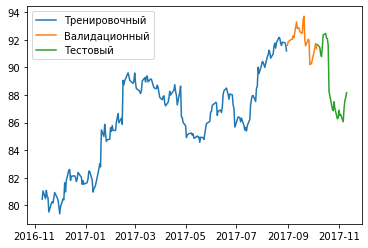

In [20]:
# Делим данные на выборки
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Тренировочный', 'Валидационный', 'Тестовый'])

## 3. Обучение

За основу возьмем архитектуру LSTM. 

In [21]:
# Создаем модель
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

2022-06-22 23:44:41.982445: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-22 23:44:41.982525: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-22 23:44:41.982578: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (erick-X555DG): /proc/driver/nvidia/version does not exist
2022-06-22 23:44:41.984744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
# Проверяем модель
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20,065
Trainable params: 20,065
Non-trainable params: 0
_________________________________________________________________


In [23]:
%%time
# Обучаем
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=120)

Epoch 1/120
7/7 [==============================] - 8s 324ms/step - loss: 7417.1328 - mean_absolute_error: 86.0604 - val_loss: 8356.5459 - val_mean_absolute_error: 91.4096
Epoch 2/120
7/7 [==============================] - 0s 22ms/step - loss: 7308.1650 - mean_absolute_error: 85.4257 - val_loss: 8246.2178 - val_mean_absolute_error: 90.8041
Epoch 3/120
7/7 [==============================] - 0s 25ms/step - loss: 7192.1387 - mean_absolute_error: 84.7439 - val_loss: 8094.9194 - val_mean_absolute_error: 89.9671
Epoch 4/120
7/7 [==============================] - 0s 25ms/step - loss: 7031.0361 - mean_absolute_error: 83.7887 - val_loss: 7894.9424 - val_mean_absolute_error: 88.8488
Epoch 5/120
7/7 [==============================] - 0s 23ms/step - loss: 6826.8232 - mean_absolute_error: 82.5608 - val_loss: 7647.8755 - val_mean_absolute_error: 87.4473
Epoch 6/120
7/7 [==============================] - 0s 22ms/step - loss: 6566.8218 - mean_absolute_error: 80.9693 - val_loss: 7323.7920 - val_mean_abs

7/7 [==============================] - 0s 26ms/step - loss: 10.5820 - mean_absolute_error: 2.6648 - val_loss: 34.4581 - val_mean_absolute_error: 5.7986
Epoch 51/120
7/7 [==============================] - 0s 21ms/step - loss: 10.5799 - mean_absolute_error: 2.6766 - val_loss: 35.3952 - val_mean_absolute_error: 5.8789
Epoch 52/120
7/7 [==============================] - 0s 22ms/step - loss: 10.6126 - mean_absolute_error: 2.6849 - val_loss: 36.0272 - val_mean_absolute_error: 5.9324
Epoch 53/120
7/7 [==============================] - 0s 23ms/step - loss: 10.6205 - mean_absolute_error: 2.6864 - val_loss: 35.5251 - val_mean_absolute_error: 5.8900
Epoch 54/120
7/7 [==============================] - 0s 24ms/step - loss: 10.5953 - mean_absolute_error: 2.6806 - val_loss: 34.6782 - val_mean_absolute_error: 5.8176
Epoch 55/120
7/7 [==============================] - 0s 25ms/step - loss: 10.5750 - mean_absolute_error: 2.6735 - val_loss: 34.5945 - val_mean_absolute_error: 5.8104
Epoch 56/120
7/7 [=====

Epoch 100/120
7/7 [==============================] - 0s 23ms/step - loss: 2.7611 - mean_absolute_error: 1.3690 - val_loss: 13.0267 - val_mean_absolute_error: 3.5474
Epoch 101/120
7/7 [==============================] - 0s 22ms/step - loss: 2.6767 - mean_absolute_error: 1.3663 - val_loss: 8.5534 - val_mean_absolute_error: 2.8447
Epoch 102/120
7/7 [==============================] - 0s 27ms/step - loss: 2.3711 - mean_absolute_error: 1.2611 - val_loss: 5.5397 - val_mean_absolute_error: 2.2492
Epoch 103/120
7/7 [==============================] - 0s 22ms/step - loss: 2.2677 - mean_absolute_error: 1.2205 - val_loss: 9.7117 - val_mean_absolute_error: 3.0474
Epoch 104/120
7/7 [==============================] - 0s 26ms/step - loss: 1.9183 - mean_absolute_error: 1.1365 - val_loss: 6.6052 - val_mean_absolute_error: 2.4804
Epoch 105/120
7/7 [==============================] - 0s 22ms/step - loss: 1.8803 - mean_absolute_error: 1.1346 - val_loss: 6.6467 - val_mean_absolute_error: 2.4922
Epoch 106/120
7

7/7 [==============================] - 2s 5ms/step


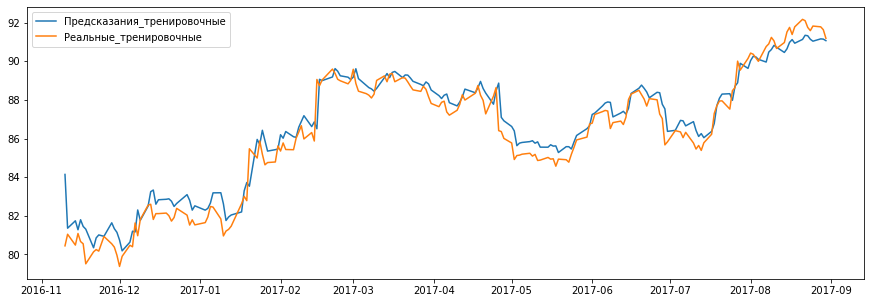

In [24]:
# Сравним предсказания на тренировочных данных
train_predictions = model.predict(X_train).flatten()

plt.figure(figsize=(15,5))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Предсказания_тренировочные', 'Реальные_тренировочные'])

1/1 [==============================] - 0s 45ms/step


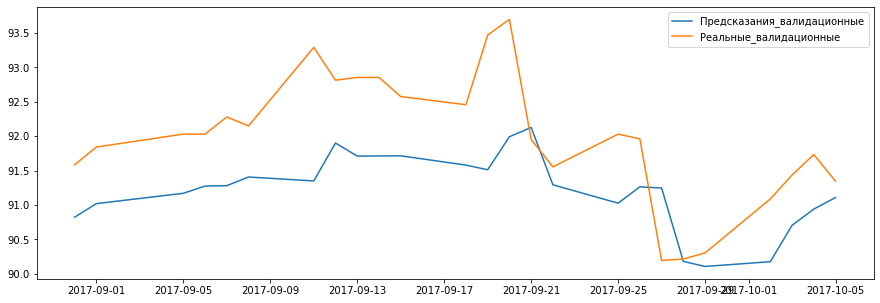

In [25]:
# Сравним предсказания на валидационных данных
val_predictions = model.predict(X_val).flatten()

plt.figure(figsize=(15,5))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Предсказания_валидационные', 'Реальные_валидационные'])

1/1 [==============================] - 0s 43ms/step


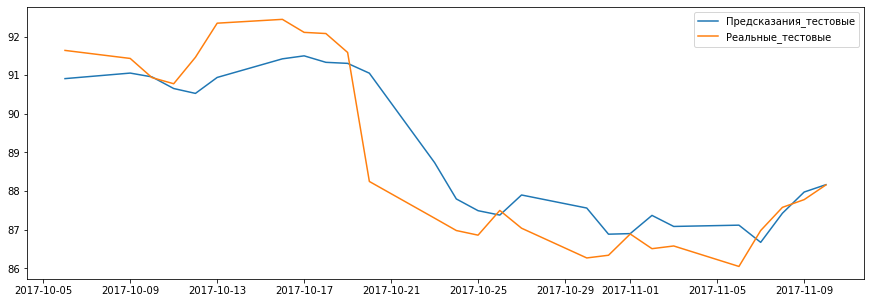

In [26]:
# Сравним предсказания на валидационных данных
test_predictions = model.predict(X_test).flatten()

plt.figure(figsize=(15,5))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Предсказания_тестовые', 'Реальные_тестовые'])

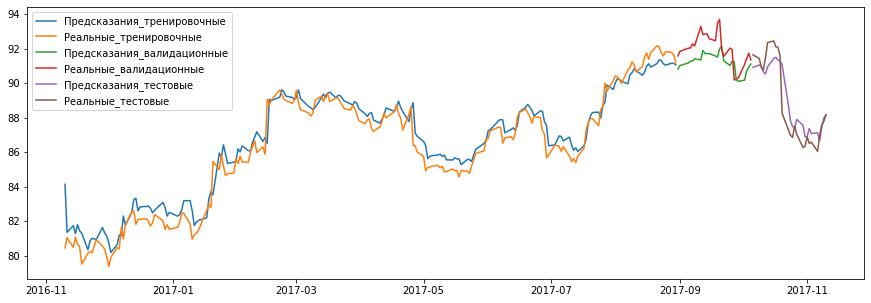

In [28]:
# Посмотрим итооговую картину
plt.figure(figsize=(15,5))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Предсказания_тренировочные',
            'Реальные_тренировочные',
            'Предсказания_валидационные', 
            'Реальные_валидационные',
            'Предсказания_тестовые', 
            'Реальные_тестовые'])

# Вывод:
В целом ошибка меньше одно доллара. И модель обучается достаточно быстро.
Можно в конце каждой сессии дообучать модель под актуальные данные и предсказывать цену закрытия на следующий день. 
Есть еще, что улучшить, но модель сильно лучше чем модель построенная на LGBM. 
Можно приступать к тестированию.